# Нейронная сеть tensorflow

# Итоговое задание №2. Прогнозирование конечных свойств новых материалов (композиционных материалов)
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. 

Предсказание (из семинара 22): 
* модуль упругости при растяжении
* прочности при растяжении
* cоотношение матрица-наполнитель

Предсказание (из итогового вебинара 26.11.2022):
* модуль упругости при растяжении
* прочности при растяжении

In [9]:
import numpy as np
import pandas as pd

In [10]:
# считывание данных из файла
def load_simple_df(full_nm_str):
    sdf = pd.read_csv('../data/interim/'+full_nm_str+'.csv', sep=';',index_col=0) # Загрузка и создание датафрейма из csv файла
    return sdf

#считывание всех наборов для одного из целевых показателей
def load_data(nm_str):
    x_train = load_simple_df('X_train_'+nm_str)
    y_train = load_simple_df('y_train_'+nm_str)
    x_test = load_simple_df('X_test_'+nm_str)
    y_test=load_simple_df('y_test_'+nm_str)
    x_val=load_simple_df('X_val_'+nm_str)
    y_val=load_simple_df('y_val_'+nm_str)
    return (x_train, y_train, x_test, y_test, x_val, y_val)

Нейронная сеть

In [11]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

In [76]:
# тренировка модели 
def try_tensor(x_train, y_train, x_val, y_val):
    tensor_model = tf.keras.Sequential()
    tensor_model.add(Dense(128, input_dim = 12, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(128, input_dim = 12, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(128, input_dim = 12, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    #tensor_model.add(Dense(128, activation = 'relu'))
    #tensor_model.add(Dropout(0.2))
    #tensor_model.add(Dense(128, activation = 'relu'))
    #tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(64, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(32, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(16, activation = 'relu'))
    tensor_model.add(Dropout(0.2))
    tensor_model.add(Dense(1, activation = 'relu'))

    #([x_train, Dense(12, activation='relu'),
    #                                Dense(128, activation='relu'),
    #                                Dense(128, activation='relu'),
    #                                Dense(128, activation='relu'),
    #                                Dense(64, activation='relu'),
    #                                Dense(32, activation='relu'),
    #                                Dense(16, activation='relu'),
    #                                Dense(1)])
    tensor_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                        loss='mean_squared_error')

    tensor_model.summary()
    model_hist = tensor_model.fit(x_train, y_train, epochs=70, verbose=1,
                                    validation_split = 0.2)  
    model_hist.history                                                 
    
    MSE = mean_squared_error(y_val, tensor_model.predict(x_val.values))
    R2 = r2_score(y_val, tensor_model.predict(x_val.values))

    return (MSE, R2, tensor_model, model_hist)

In [52]:
#запуск модели и вычисление метрик
def fit_tensor(nm_file_str, nm_error_df_str):
    #считываем данные из файлов
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_df = pd.DataFrame()
    x_val_df = pd.DataFrame()
    y_val_df = pd.DataFrame()

    (x_train_df, y_train_df, x_test_df, y_test_df, x_val_df, y_val_df) = load_data(nm_file_str)

    #обучаем модель
    (MSE, R2, prediction_y_tensor, hist_y_tensor) = try_tensor(x_train_df, y_train_df, x_val_df, y_val_df)
    tensor_errors = pd.DataFrame({'model_name':'Tensor',
                              'target_var':[nm_error_df_str],
                              'MSE':[MSE],
                              'R2':[R2]})
    return (tensor_errors, x_val_df, y_val_df, prediction_y_tensor, hist_y_tensor)

In [53]:
#визуализация
import matplotlib.pyplot as plt

def model_loss_plot(model_hist, nm_param):
    plt.figure(figsize=(17,5))
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])
    plt.title('График потерь')
    plt.ylabel('MSE')
    plt.xlabel('Эпоха')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

In [54]:
#визуализация
import matplotlib.pyplot as plt

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Валидационные и прогнозные значения: {model_name}')
    plt.plot(orig, label='Валидация')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

Для каждой характеристики запускаем последовательно обучение моделей

In [77]:
#датасет со значениями ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

(fit_errors, x_val_elastic, y_val_elastic, y_elastic_predict, y_elastic_hist) = fit_tensor('elastic', 'Модуль упругости при растяжении, ГПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
#(fit_errors, x_val_strength, y_val_strength, y_strength_predict, y_strength_hist) = fit_tensor('strength', 'Прочность при растяжении, МПа')
#errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
#(fit_errors, x_val_matrix, y_val_matrix, y_matrix_predict, y_matrix_hist) = fit_tensor('matrix', 'Соотношение матрица-наполнитель')
#errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
errors_df

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 128)               1664      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               16512     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 128)               16512     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 64)              

,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",Tensor,0.029507,-0.027877


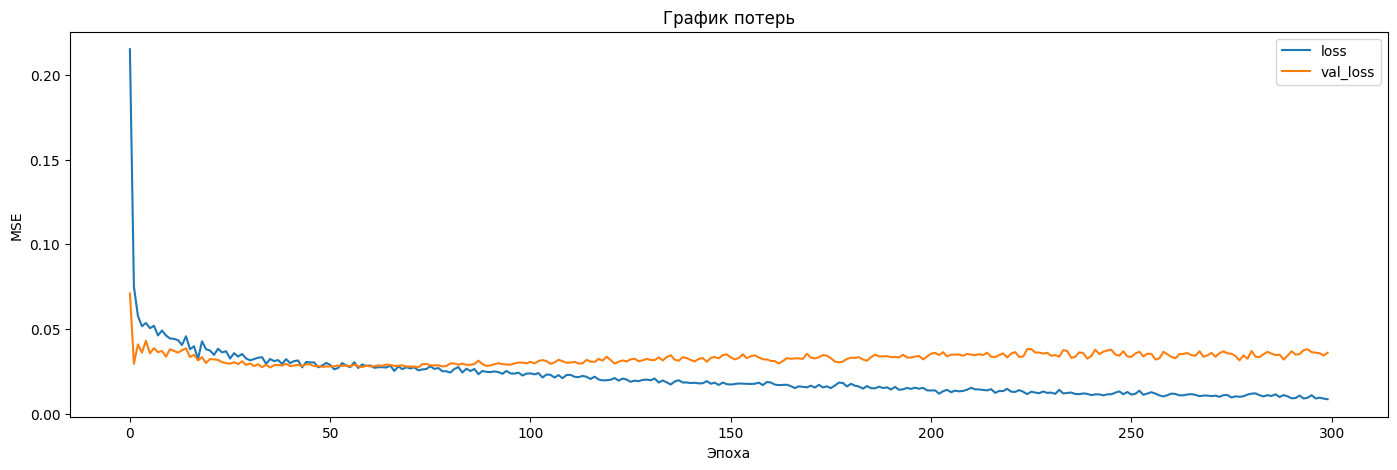

In [73]:
model_loss_plot(y_elastic_hist, 'Модуль упругости при растяжении, ГПа')
#model_loss_plot(y_strength_hist, 'Прочность при растяжении, МПа')
#model_loss_plot(y_matrix_hist, 'Соотношение матрица-наполнитель')

7/7 [==============================] - 0s 1ms/step


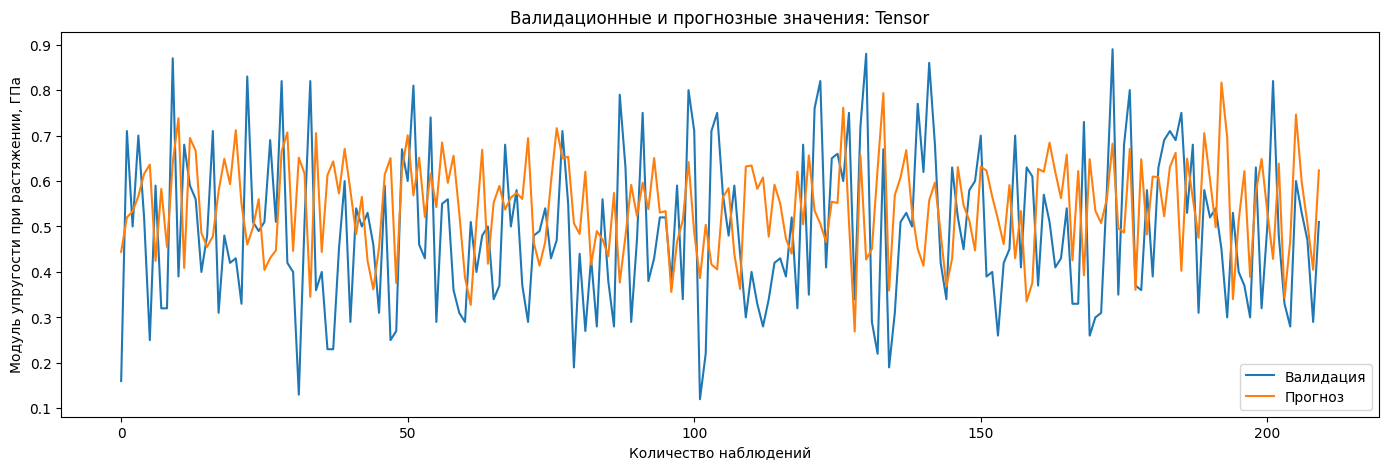

In [74]:
actual_and_predicted_plot(y_val_elastic.values,
                            y_elastic_predict.predict(x_val_elastic), 
                            'Модуль упругости при растяжении, ГПа',
                            'Tensor')
#actual_and_predicted_plot(y_val_strength.values,
#                            y_strength_predict.predict(x_val_strength), 
#                            'Прочность при растяжении, МПа', 
#                            'Tensor')
#actual_and_predicted_plot(y_val_matrix.values,
#                            y_matrix_predict.predict(x_val_matrix), 
#                            'Соотношение матрица-наполнитель', 
#                            'Tensor')